# Exercise 4: Thermostatic HVAC Control

## Overview

In this exercise, we design a simple thermostatic controller for heating a single-zone building modeled with an interpretable $RC$ model (see Exercise 3).

## Set up

Load the required libraries and 10-minute measurement data from an occupied, semi-detached house in the UK [1] (change the ```data_path``` variable accordingly).

[1] Hollick, F; Wingfield, J; (2018) Two periods of in-situ measurements from an occupied, semi-detached house in the UK [Dataset]. 10.14324/000.ds.10087216.

In [1]:
# Import libraries
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Plotting figures default
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (10,4)

In [2]:
# Load measurement data
data_path = 'C:\\Users\\ucbva19\\Git projects\\BENV0092\\data raw'
raw_data = pd.read_csv(f'{data_path}\\10mins_solpap_2016.csv', index_col = 0)
raw_data.index = pd.to_datetime(raw_data.index, format="%d/%m/%Y %H:%M")

# Fill missing data with linear interpolation
data = raw_data.copy().interpolate('linear')
assert(data.isna().all().sum() == 0)

# Lead T_in values (target variable)
data['T_Average_lead_1'] = data['T_Average (degC)'].shift(-1)
data['T_diff'] = data['T_External (degC)'] - data['T_Average (degC)']

# Drop NaNs created from the shift operator
data = data.dropna()

# discretization step at 10 minutes
dt_h = 1/6

T_in  = data['T_Average (degC)'].values          # °C
T_out = data['T_External (degC)'].values         # °C
u     = data['P_tot (W)'].values        # kW
t_idx = data.index

## RC Model

As in Exercise 3, we use a single-zone linear model, *ignoring solar radiation* gains for simplicity:
<center>
$
    \Delta T_k := 
T_{k+1}-T_{k}
= \alpha_1(T_{\mathrm{ext},k} - T_{k})
+ \alpha_2 u_k + w_k,
$    
</center>

Where:
- $T_k$ : indoor temperature (°C), **state**
- $u_k$ : heating power input (kW), **control**
- $T_{\mathrm{ext}, k}$ : outdoor temperature forecast (°C), **disturbance**
- $w_k$ : process noise (°C), modeling unmodeled gains/losses

As $\alpha_1$ increases, the envelope becomes ``leakier,'' whereas as $\alpha_2$, heat gains increase.
For this exercise, we consider the following values
- $\alpha_1 = 0.00088969,$
- $\alpha_{2} = 0.00674676,$
which correspond to a typical small/medium dwelling.

---

## Control Policy

The controller works takes as input a reference setpoint, $T_{\textrm{ref}}$, for the thermostat, which turns the heating on or off (power is zero or maximum) given the curent temperature measurement $T_k$, where $k$ is the time step.

**Policy**: For $k=1, \dots, N$:
- If $T_k < T_\textrm{{ref}}$, then set $u_k=u_{\textrm{max}}$.
- Else, $u_k=0$.

Thermostatic controller
Total Energy (kWh): 92.0


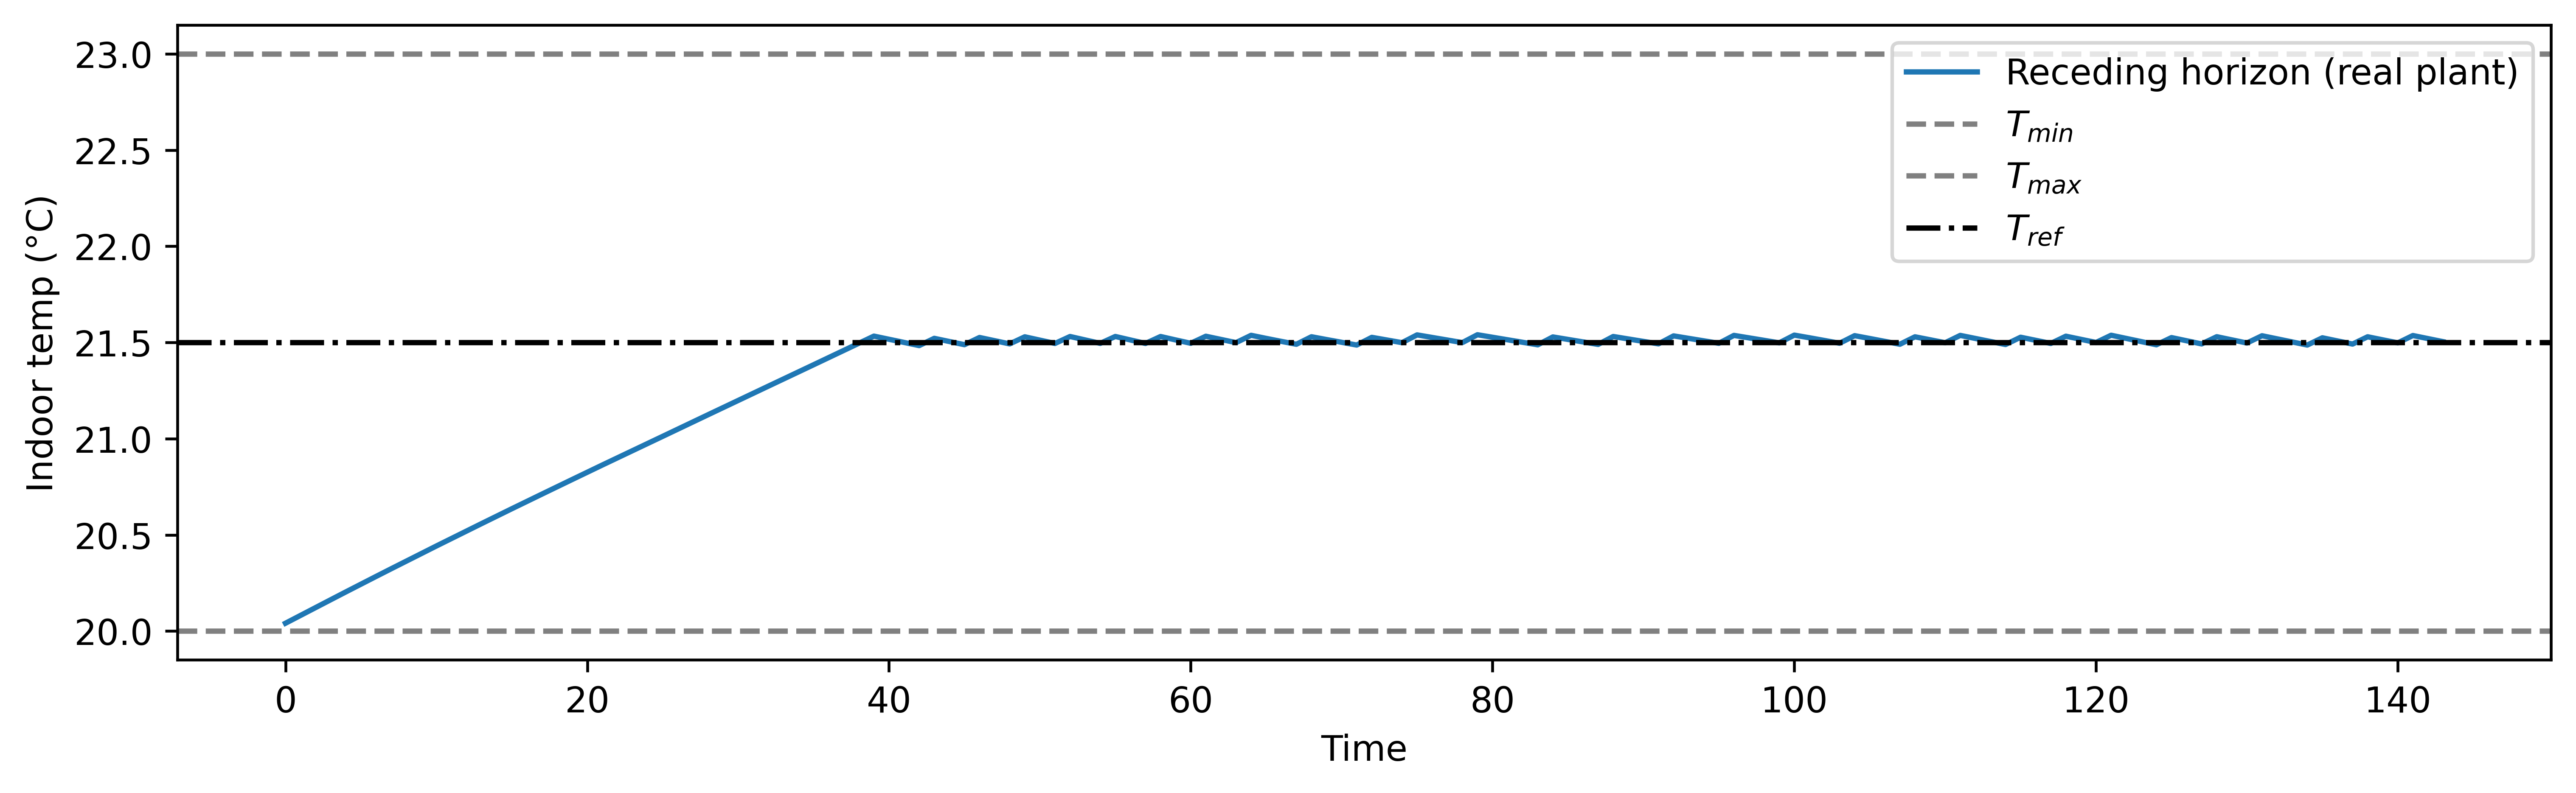

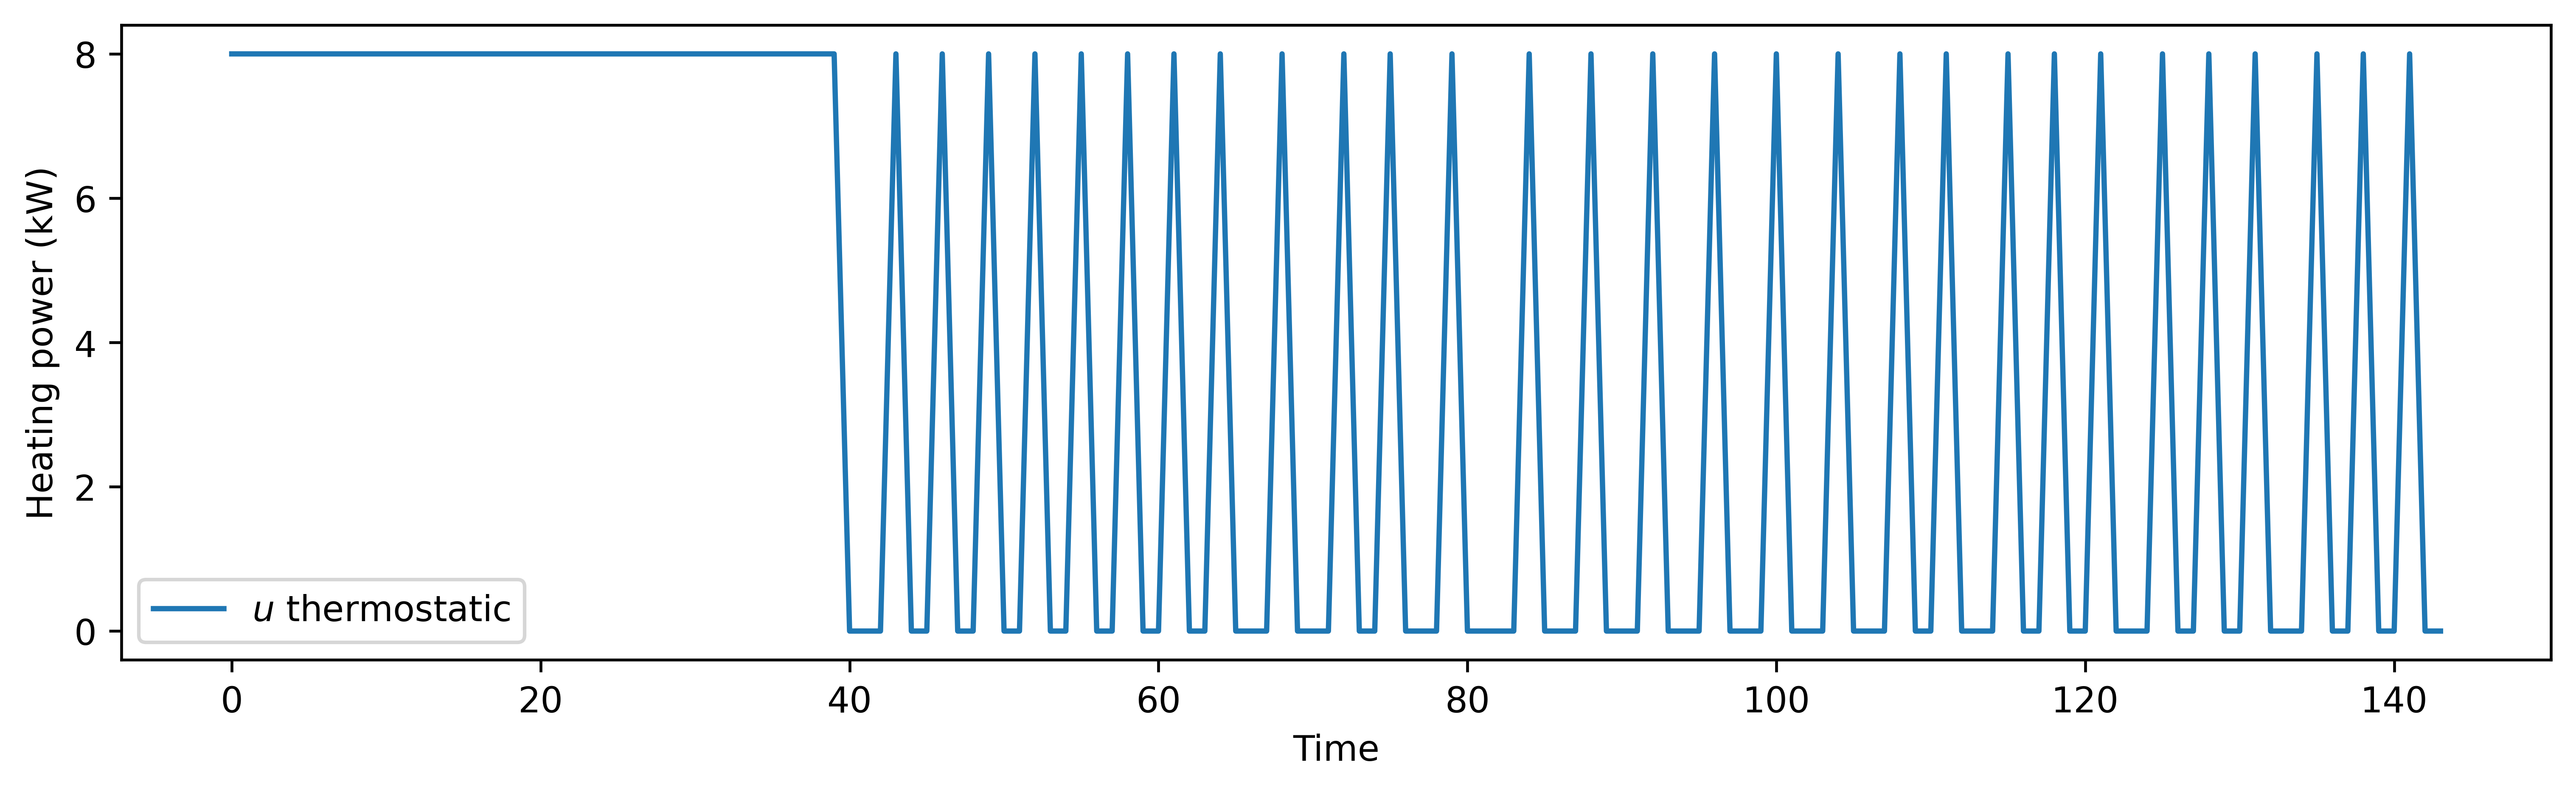

In [3]:
###### Closed-loop Thermostat Baseline
# Rule-based approach, heat at full power or turned off

def thermostatic_ref_control(T_current, T_ref, u_max, u_min):
    '''Simple thermostatic controller, takes as input current inner temperature and setpoint, 
        returns control action for next time step'''    
    if T_current <= T_ref:
        u_next = u_max
    else:
        u_next = u_min
        
    return u_next

#alpha_1 = 0.0208
#alpha_2 = 0.16

alpha_1 = 0.00088969
alpha_2 = 0.00674676

# controller parameters
N_steps = 144
T_min = 20
T_max = 23
T_ref = (T_min+T_max)/2
u_max = 8
u_min = 0

# thermostat setpoint/ reference
T_ref = (T_min + T_max)/2

# Starting temperature
T0_real = 20

# Storage
u_applied = np.zeros(N_steps)
T_real = np.zeros(N_steps+1)

# Initial state (real and measured)
T_real[0] = T0_real

for k in range(N_steps):

    u_control = thermostatic_ref_control(T_real[k], T_ref, u_max, u_min)

    T_real[k+1] = T_real[k] + alpha_1*(T_out[k] - T_real[k]) + alpha_2*u_control
    
    # implement action
    u_applied[k] = u_control


print('Thermostatic controller')
print(f"Total Energy (kWh): {(u_applied.sum())*dt_h}")

# Temperature trajectories
plt.figure(figsize=(10,3))
plt.plot(T_real[1:], label="Receding horizon (real plant)")
plt.axhline(T_min, color="grey", linestyle="--", label="$T_{min}$")
plt.axhline(T_max, color="grey", linestyle="--", label="$T_{max}$")
plt.axhline(T_ref, color="black", linestyle="-.", label="$T_{ref}$")
plt.ylabel("Indoor temp (°C)")
plt.xlabel("Time")
plt.legend()
plt.show()

# Inputs
fig, ax1 = plt.subplots(figsize=(10,3))
ax1.plot(u_applied, label="$u$ thermostatic")
ax1.set_ylabel("Heating power (kW)")
ax1.set_xlabel("Time")
ax1.legend()
plt.show()

## Sensitivity analysis

We examine the sensitivity of the heating power required to maintain a reference setpoint to model parameters. In the following, we vary `alpha_1`, which indicates the fabric insulation, with higher values indicating a more "leaky" envelope.

Thermostatic controller
Total Energy (kWh): 37.33333333333333
Thermostatic controller
Total Energy (kWh): 38.666666666666664
Thermostatic controller
Total Energy (kWh): 44.0
Thermostatic controller
Total Energy (kWh): 98.66666666666666
Thermostatic controller
Total Energy (kWh): 192.0
Thermostatic controller
Total Energy (kWh): 192.0


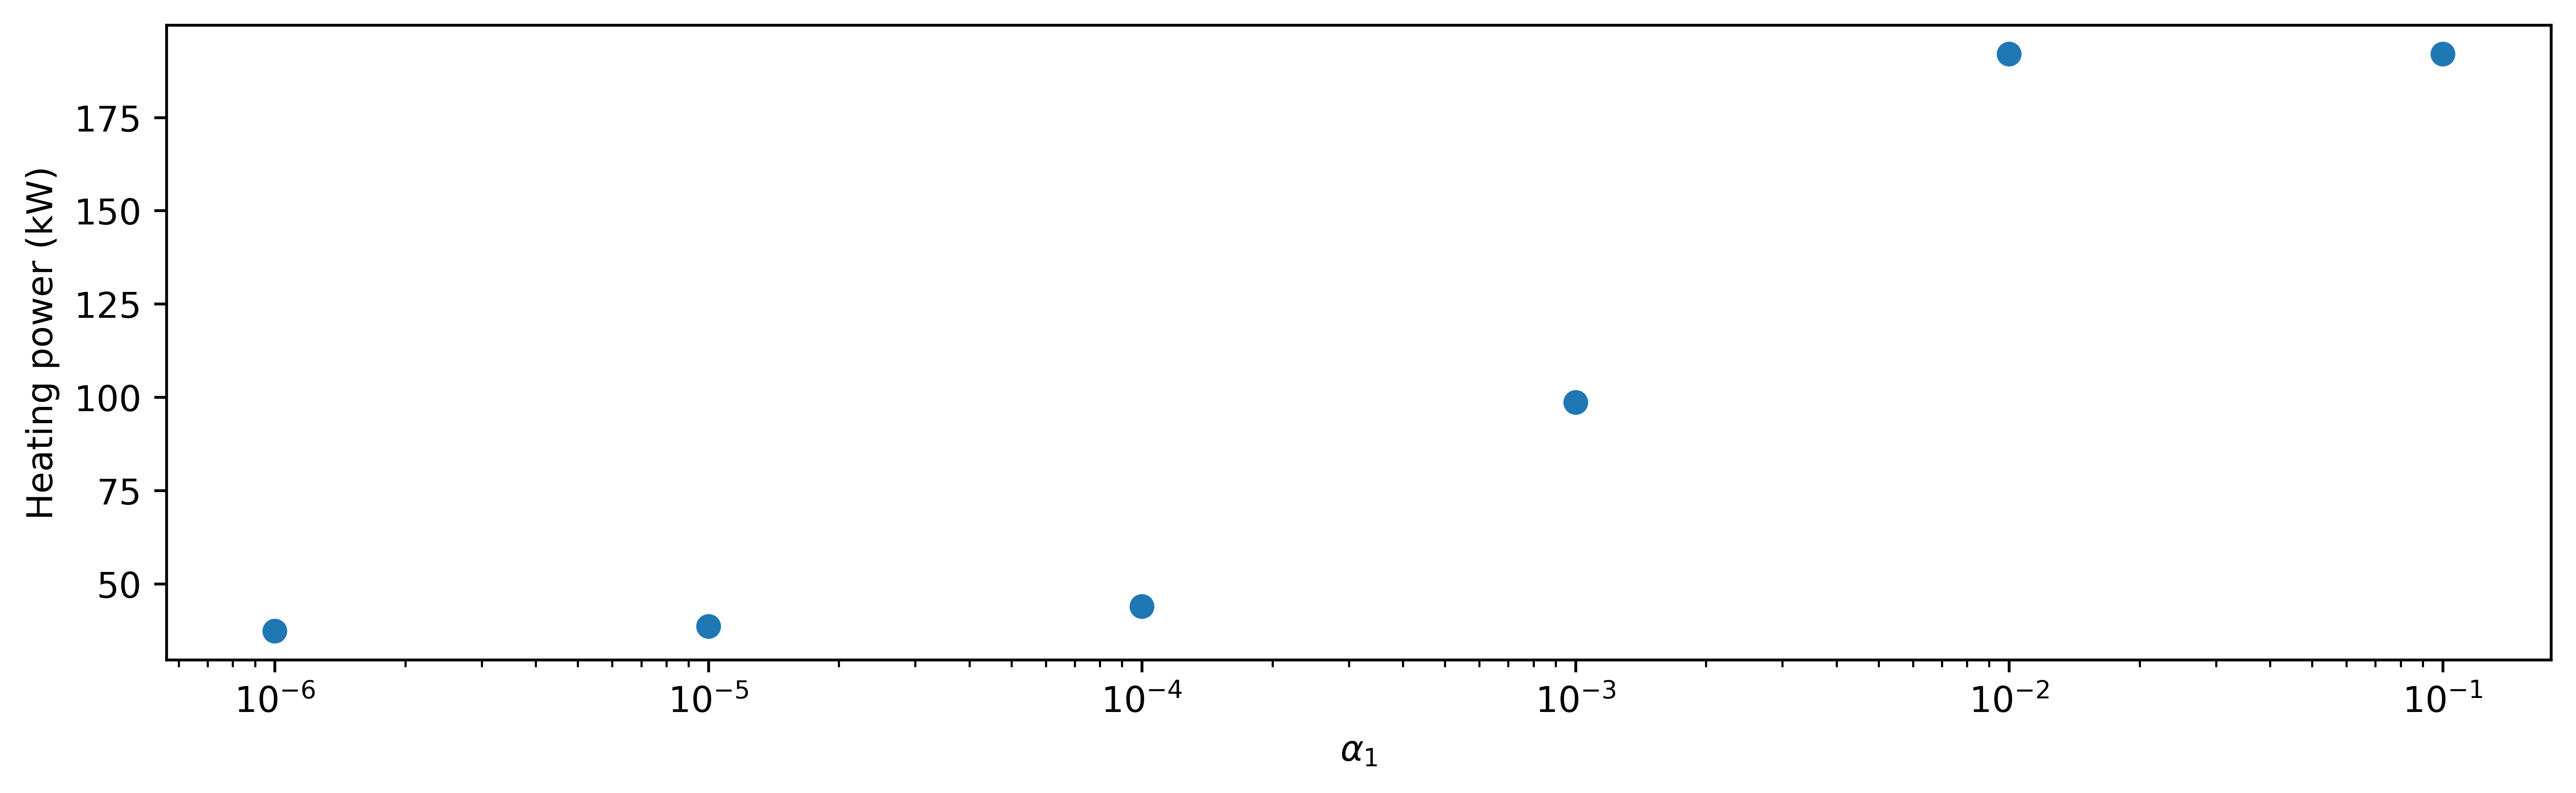

In [4]:
num_points = 10
alpha_1_grid = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])

Total_energy_array = np.zeros(len(alpha_1_grid))

for i, temp_alpha_1 in enumerate(alpha_1_grid):
    
    u_applied = np.zeros(N_steps)
    T_real = np.zeros(N_steps+1)

    # Initial state (real and measured)
    T_real[0] = T0_real

    for k in range(N_steps):
    
        u_control = thermostatic_ref_control(T_real[k], T_ref, u_max, u_min)
    
        T_real[k+1] = T_real[k] + temp_alpha_1*(T_out[k] - T_real[k]) + alpha_2*u_control
        
        # implement action
        u_applied[k] = u_control


    print('Thermostatic controller')
    print(f"Total Energy (kWh): {(u_applied.sum())*dt_h}")
    Total_energy_array[i] = (u_applied.sum())*dt_h


fig, ax1 = plt.subplots(figsize=(10,3))
ax1.scatter(alpha_1_grid, Total_energy_array)
ax1.set_ylabel("Heating power (kW)")
ax1.set_xlabel(r"$\alpha_1$")
ax1.set_xscale('log')
plt.show()

## Step response

We visually assess performance when the reference setpoint changes over time as a step function.

Thermostatic controller
Total Energy (kWh): 88.0
(144,)


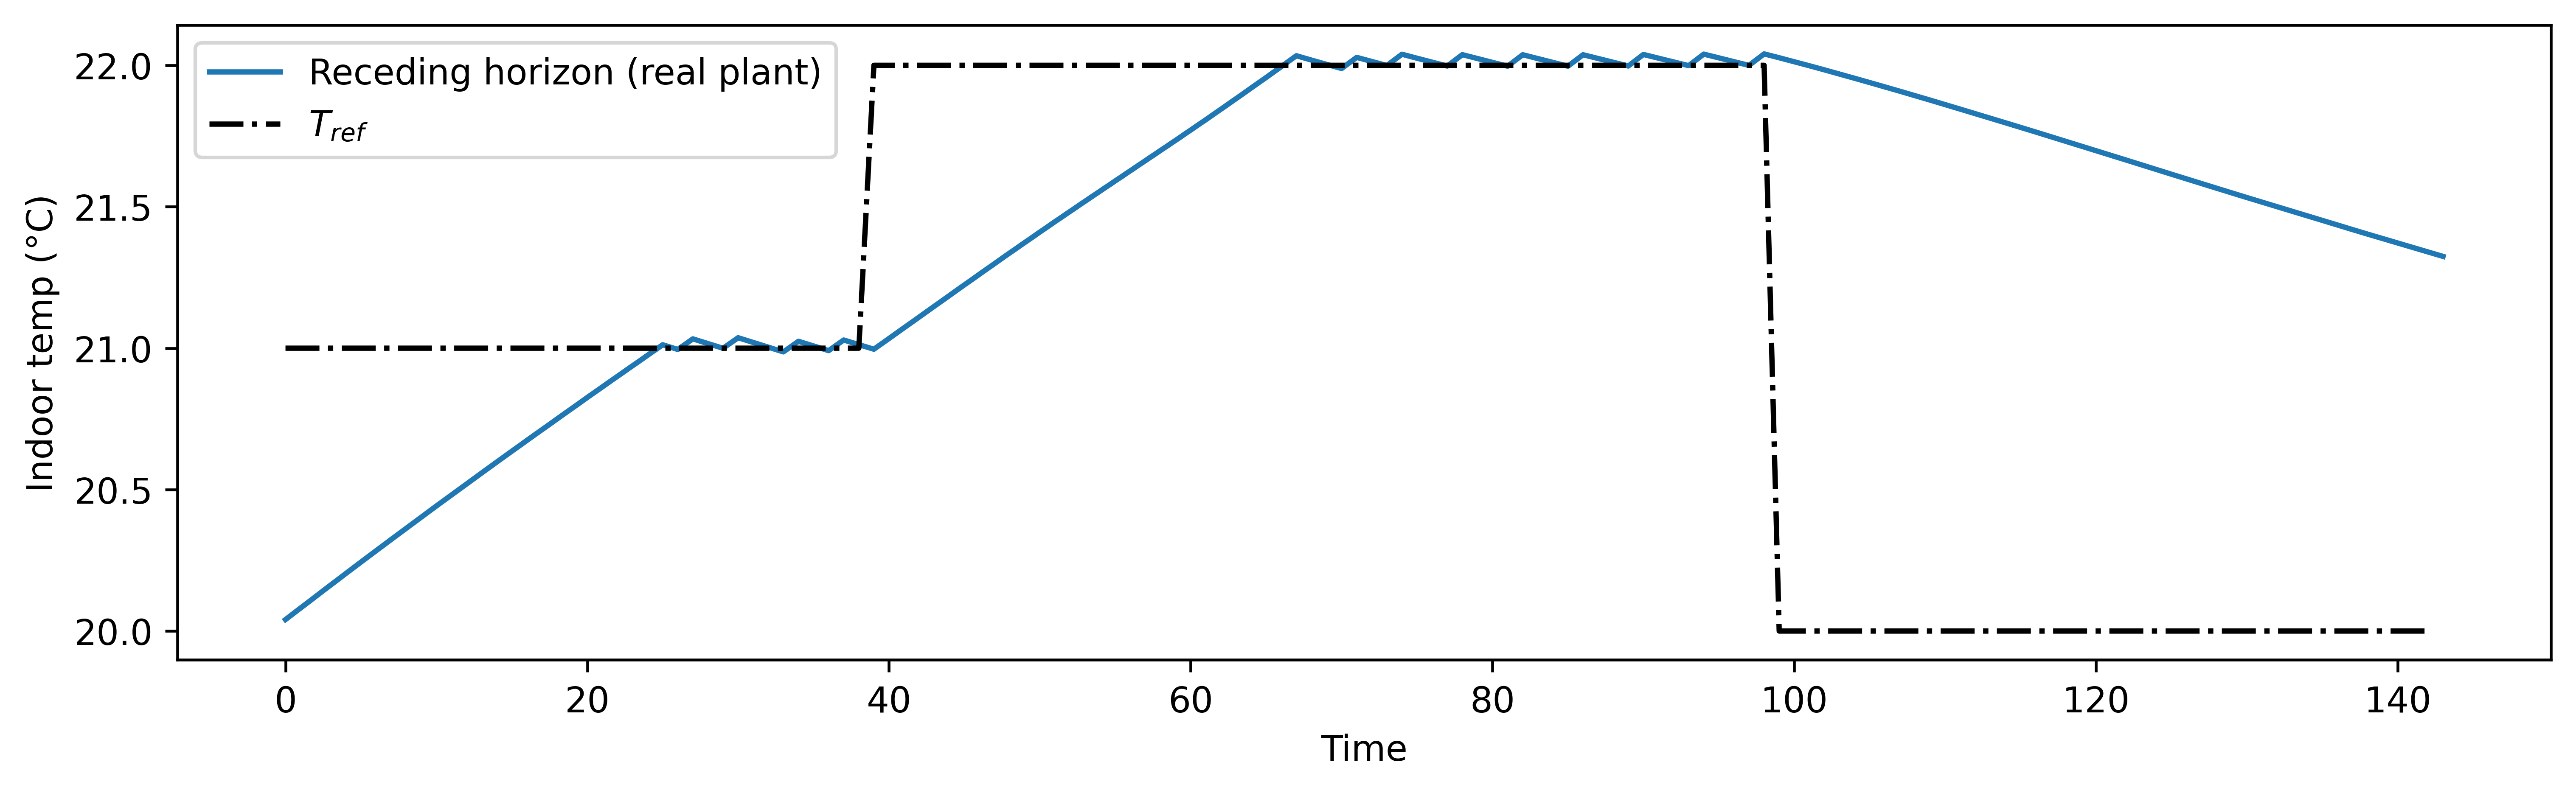

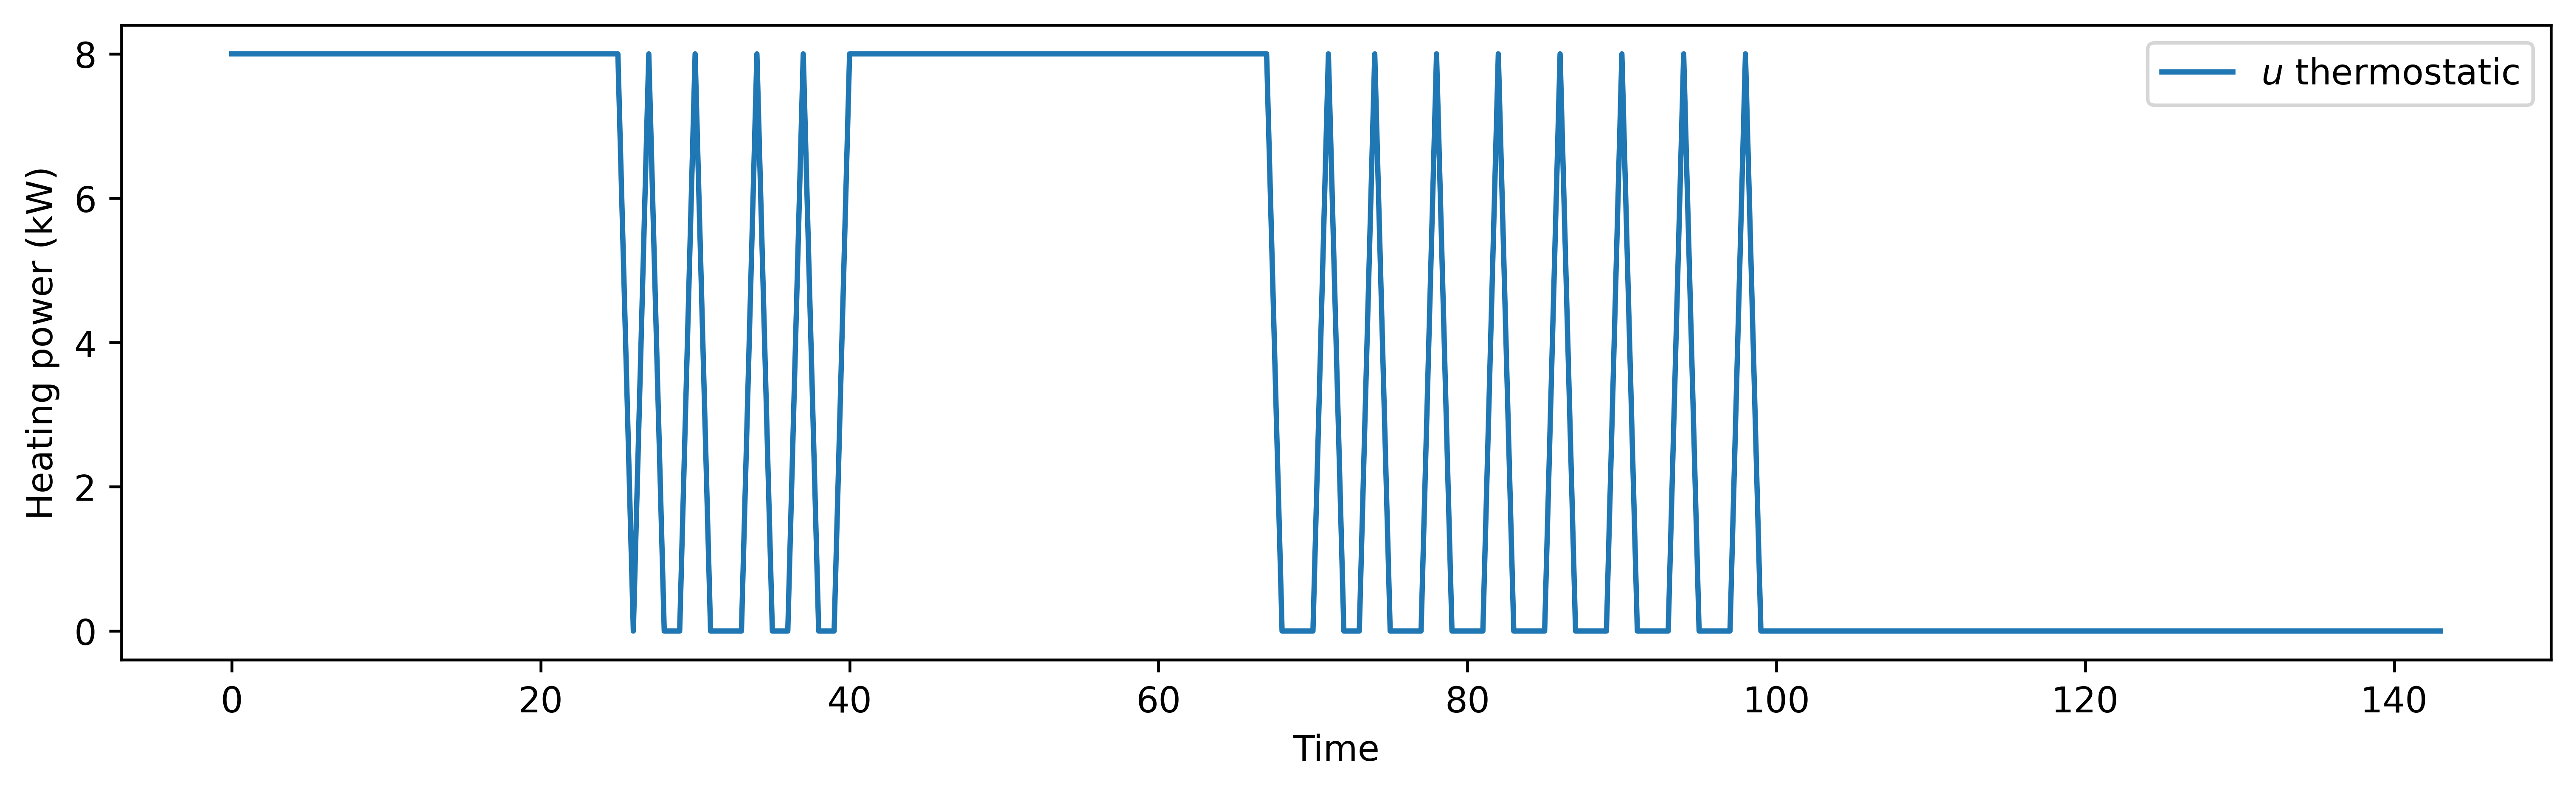

In [5]:
# thermostat setpoint/ reference
T_ref_k = np.array(40*[21]+60*[22]+44*[20])

# try other set of parameters
#alpha_1 = 0.0208
#alpha_2 = 0.16

#alpha_1 = 0.00088969
#alpha_2 = 0.00674676

# Starting temperature
T0_real = 20

# Storage
u_applied = np.zeros(N_steps)
T_real = np.zeros(N_steps+1)

# Initial state (real and measured)
T_real[0] = T0_real

for k in range(N_steps):
    
    u_control = thermostatic_ref_control(T_real[k], T_ref_k[k], u_max, u_min)

    T_real[k+1] = T_real[k] + alpha_1*(T_out[k] - T_real[k]) + alpha_2*u_control
    
    # implement action
    u_applied[k] = u_control


print('Thermostatic controller')
print(f"Total Energy (kWh): {(u_applied.sum())*dt_h}")

print(T_ref_k.shape)
# Temperature trajectories
plt.figure(figsize=(10,3))
plt.plot(T_real[1:], label="Receding horizon (real plant)")
plt.plot(T_ref_k[1:], color="black", linestyle="-.", label="$T_{ref}$" )
plt.ylabel("Indoor temp (°C)")
plt.xlabel("Time")
plt.legend()
plt.show()

# Inputs
fig, ax1 = plt.subplots(figsize=(10,3))
ax1.plot(u_applied, label="$u$ thermostatic")
ax1.set_ylabel("Heating power (kW)")
ax1.set_xlabel("Time")
ax1.legend()
plt.show()